In [79]:
import numpy as np
import pandas as pd
import math as mat
import scipy
from scipy import optimize
import matplotlib.pyplot as plt
import seaborn as sns

In [51]:
def gaussian_kernel(x1,x2,noise,length): #Generate the kernel (cov) of the Gaussian Process
    n1 = x1.shape[0]
    n2 = x2.shape[0]
    kernel = np.zeros((n1,n2))
    for i in range(n1):
        for j in range(n2):
            kernel[i,j] = noise**2*mat.exp(-0.5*((x1[i]-x2[j])/length)**2)
    return kernel


In [52]:
def LLH_GP(x,y,m,noise,length, sf = 0): #Compute the likelihood of the data (add sf if consider noise)
    ker = gaussian_kernel(x,x, noise, length)
    ker = ker+np.diag([sf]*len(x))
    return 1/2*(mat.log(np.linalg.det(ker))+np.dot(np.dot(np.transpose(y-m),
                                                       np.linalg.inv(ker)),(y-m)))



In [53]:
def opt_hyparams(x,y): #Find the hyperparameters that optimize LLH without noise
    ini = np.array([0,1,1])
    opt = optimize.minimize(lambda params: LLH_GP(x, y, params[0], params[1], params[2]),
                            ini)
    params = opt.x
    m = params[0]
    noise = abs(params[1])
    length = abs(params[2])
    sf = 0
    return m, noise, length, sf  



In [54]:
def opt_hyparams_noise(x,y): #Find the hyperparameters that optimize LLH with noise
    ini = np.array([0,1,1,1])
    opt = optimize.minimize(lambda params: LLH_GP(x, y, params[0], 
                                                  params[1], params[2], params[3]),ini)
    params = opt.x
    m = params[0]
    noise = abs(params[1])
    length = abs(params[2])
    sf = abs(params[3])
    return m, noise, length, sf

In [56]:
#Generates the mean and covariance of the posterior distribution in the given grid (xn) 
#from data (x,y) and the optimized parameters (mean->m, noise, length, noise in y -> sf)
def gp_posterior(x, y, xn, m, noise, length, sf = 0): 
    kxx = gaussian_kernel(x, x, noise = noise, length = length)
    kxxn = gaussian_kernel(x, xn, noise = noise, length = length)
    kxnx = gaussian_kernel(xn, x, noise = noise, length = length)
    kxnxn = gaussian_kernel(xn, xn, noise = noise, length = length)
    core = np.linalg.inv(kxx + np.diag([sf]*len(x)))
    En = np.dot(np.dot(kxnx, core), y)
    covn = kxnxn - np.dot(np.dot(kxnx, core), kxxn)  
    
    return En, covn



In [69]:
def data_posterior(x, E, cov):
    data = pd.DataFrame({'x': x})
    data['Mean'] = E
    data['StdDev'] = np.diag(cov)
    #Generate the 5 samples as multivariate normals with 0 mean and covariance sigma
    for i in range(5):
        data['y'+str(i)] = np.random.multivariate_normal(E, cov)
    return data  


/home/roger/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:7: RuntimeWarning: covariance is not positive-semidefinite.


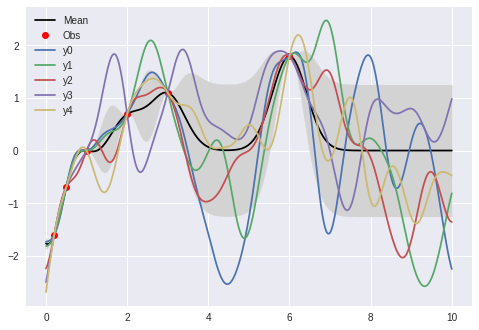

In [91]:
#plot example
def f1(x):
    return np.log(x)

x = np.array([0.2,0.5,1,2,3,6])
y = f1(x)
m, noise, length, sf = opt_hyparams(x,y)
n = 500
xn = np.linspace(0,10,n)
E, cov = gp_posterior(x, y, xn, m, noise, length, sf)
data = data_posterior(xn, E, cov)

plt.plot(data['x'],data['Mean'], color = 'black', label = 'Mean')
plt.plot(x,y, 'ro', label = 'Obs')
plt.plot(data['x'], data['y0'], label = 'y0')
plt.plot(data['x'], data['y1'], label = 'y1')
plt.plot(data['x'], data['y2'], label = 'y2')
plt.plot(data['x'], data['y3'], label = 'y3')
plt.plot(data['x'], data['y4'], label = 'y4')
plt.fill_between(data['x'], data['Mean']-data['StdDev'], data['Mean']+data['StdDev'], 
                 color = 'lightgrey')
plt.legend()
plt.show()